In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=4677a9e54b3cb429f846a982cb971f991448099197d46f439ccd1dfb7bbc9a0b
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import sklearn
import gc
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, Conv2D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import MinMaxScaler
from keras_self_attention import SeqSelfAttention

**LOAD DATA**


In [ ]:
# Header=[]
# Header.append('Datetime')
# for i in range (1,371) :
#   Header.append('User'+ str(i))
# print(Header)
Header=[]
for i in range (1,322) :
  Header.append('User'+ str(i))

df = pd.read_csv('/content/drive/MyDrive/dataset/electricity.csv', names=Header)
df.drop([0,1], axis=0, inplace=True)
df = df.replace(',', '', regex=True)
when = pd.date_range(start=pd.datetime(2012,1,1),freq='H',periods=len(df))

df["Datetime"]=when
df=df.set_index('Datetime')
print(df.shape)
df.info()

(26302, 321)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26302 entries, 2012-01-01 00:00:00 to 2014-12-31 21:00:00
Columns: 321 entries, User1 to User321
dtypes: int64(321)
memory usage: 64.6 MB


<ipython-input-4-936912bdc0c5>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  when = pd.date_range(start=pd.datetime(2012,1,1),freq='H',periods=len(df))


In [ ]:
df = df.astype('double')
df = df/4 #converting from kW to kWh

In [ ]:
df.head()

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User312,User313,User314,User315,User316,User317,User318,User319,User320,User321
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,5.25,24.00,78.00,140.00,68.00,310.00,7.25,256.25,67.50,75.00,...,204.25,107.50,24150.0,1071.25,1642.75,16.00,10.75,548.25,54.50,691.00
2012-01-01 01:00:00,5.00,23.00,78.00,110.75,53.25,211.25,6.00,208.25,44.75,52.75,...,200.25,72.75,23625.0,1055.50,1591.25,16.25,9.75,328.75,48.75,683.75
2012-01-01 02:00:00,5.50,22.75,78.00,86.50,47.50,161.75,4.00,183.25,46.50,44.75,...,201.75,69.75,22825.0,1029.00,1574.50,18.75,10.00,344.50,47.75,680.25
2012-01-01 03:00:00,5.00,23.00,46.75,85.00,44.50,160.25,4.50,181.50,46.00,44.25,...,200.50,97.25,21750.0,1064.75,1387.00,16.00,9.75,312.50,46.25,685.50
2012-01-01 04:00:00,5.00,22.75,34.50,94.00,49.75,179.75,5.50,178.75,55.25,60.75,...,206.75,102.50,21025.0,1108.00,1068.75,16.25,12.25,454.50,47.75,679.00


In [ ]:
df.head()

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,...,User312,User313,User314,User315,User316,User317,User318,User319,User320,User321
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-01 00:00:00,5.25,24.00,78.00,140.00,68.00,310.00,7.25,256.25,67.50,75.00,...,204.25,107.50,24150.0,1071.25,1642.75,16.00,10.75,548.25,54.50,691.00
2012-01-01 01:00:00,5.00,23.00,78.00,110.75,53.25,211.25,6.00,208.25,44.75,52.75,...,200.25,72.75,23625.0,1055.50,1591.25,16.25,9.75,328.75,48.75,683.75
2012-01-01 02:00:00,5.50,22.75,78.00,86.50,47.50,161.75,4.00,183.25,46.50,44.75,...,201.75,69.75,22825.0,1029.00,1574.50,18.75,10.00,344.50,47.75,680.25
2012-01-01 03:00:00,5.00,23.00,46.75,85.00,44.50,160.25,4.50,181.50,46.00,44.25,...,200.50,97.25,21750.0,1064.75,1387.00,16.00,9.75,312.50,46.25,685.50
2012-01-01 04:00:00,5.00,22.75,34.50,94.00,49.75,179.75,5.50,178.75,55.25,60.75,...,206.75,102.50,21025.0,1108.00,1068.75,16.25,12.25,454.50,47.75,679.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26302 entries, 2012-01-01 00:00:00 to 2014-12-31 21:00:00
Columns: 321 entries, User1 to User321
dtypes: float64(321)
memory usage: 64.6 MB


**DATA VISUALIZATION**

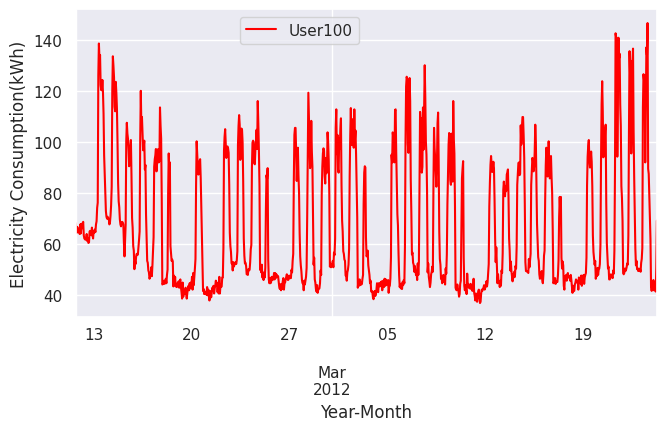

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

df.iloc[1000:2000].plot(y=['User100'] ,color=['red'])

plt.ylabel('Electricity Consumption(kWh)')
plt.xlabel('Year-Month')
plt.legend(bbox_to_anchor=(0.5, 1))
plt.show()

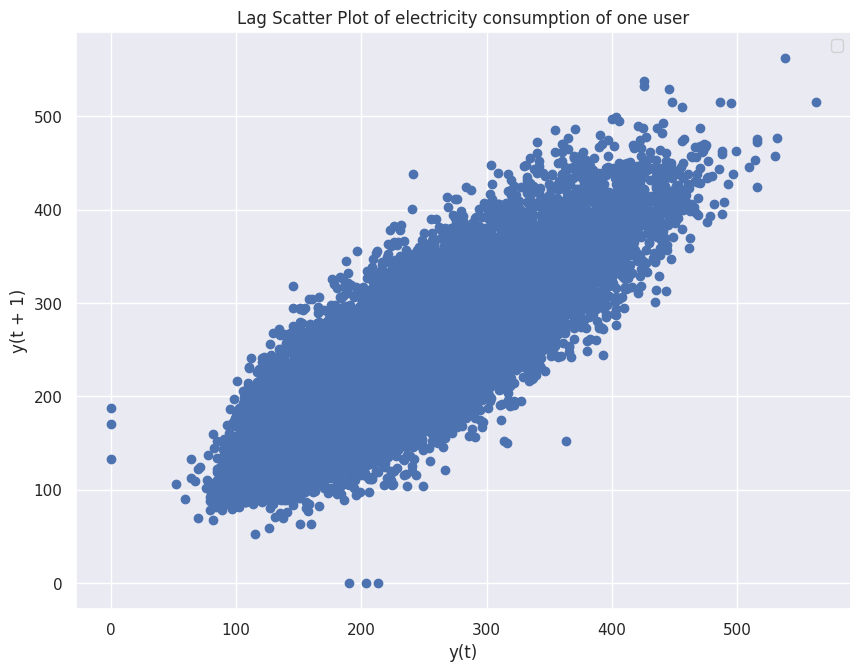

In [ ]:
from pandas.plotting import lag_plot

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(10,7.5)})

# lag scatter plot
lag_plot(df['User22'])
plt.title('Lag Scatter Plot of electricity consumption of one user')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

**MINMAX SCALING**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
dff = df
scalers={}
for i in df.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(dff[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    dff[i]=s_s

In [ ]:
def split_series(series, n_past, n_future):

  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 24
n_future = 3
n_features = 321

**ADDITIVE DECOMPOSITION to COLLECT RESIDUALS**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
residual = {}
seasonal ={}
trend= {}
d=0
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    residual[ts] = decomposition.resid.copy()


residual=pd.DataFrame(residual)
residual.columns=Header
residual=residual.fillna(0)

del(decomposition)
gc.collect()



3412

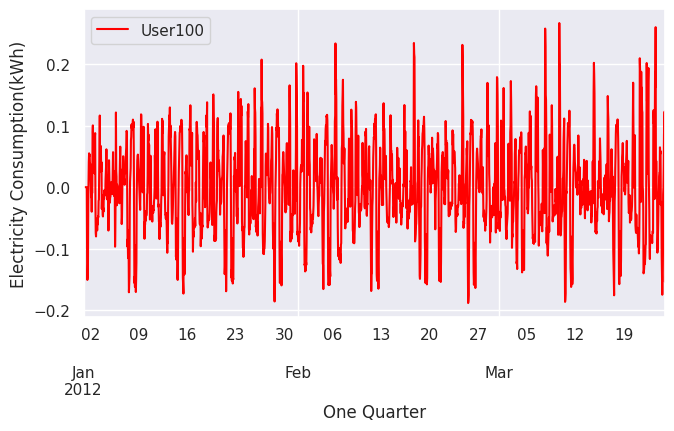

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

residual.iloc[0:2016].plot(y=['User100'] ,color=['red'])

plt.ylabel('Electricity Consumption(kWh)')
plt.xlabel('One Quarter')
plt.show()

In [ ]:
train_residual,test_residual = residual[0:23673], residual[23673:]
train_residual, valid_residual = residual[0:21306], residual[21306:23673]

In [ ]:
X_trainr, y_trainr = split_series(train_residual.values,n_past, n_future)
print(X_trainr.shape)
print(y_trainr.shape)
X_trainr = X_trainr.reshape((X_trainr.shape[0], X_trainr.shape[1],n_features))
y_trainr = y_trainr.reshape((y_trainr.shape[0], y_trainr.shape[1], n_features))
X_testr, y_testr = split_series(test_residual.values,n_past, n_future)
print(X_testr.shape)
print(y_testr.shape)
X_testr = X_testr.reshape((X_testr.shape[0], X_testr.shape[1],n_features))
y_testr = y_testr.reshape((y_testr.shape[0], y_testr.shape[1], n_features))
X_validr, y_validr = split_series(valid_residual.values,n_past, n_future)
X_validr = X_validr.reshape((X_validr.shape[0], X_validr.shape[1],n_features))
y_validr = y_validr.reshape((y_validr.shape[0], y_validr.shape[1], n_features))

(21280, 24, 321)
(21280, 3, 321)
(2603, 24, 321)
(2603, 3, 321)


In [ ]:
print(train_residual.shape)
print(test_residual.shape)
print(valid_residual.shape)

(21306, 321)
(2629, 321)
(2367, 321)


##Stacked GRU


In [ ]:
modelr = Sequential()
modelr.add(GRU(units=128,
                                 return_sequences=True,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(GRU(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelr.add(RepeatVector(n_future))
modelr.add(TimeDistributed(Dense(units=n_features, activation = 'tanh')))
modelr.compile(loss='mae', optimizer='adam')
modelr.build((None, n_past, n_features))
modelr.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 24, 128)           173184    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 128)               99072     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 3, 321)            41409     
Total params: 313,665
Trainable params: 313,665
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#modelr.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history=modelr.fit(X_trainr,y_trainr,epochs=20,validation_data=(X_validr,y_validr),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
1330/1330 [==============================] - 129s 88ms/step - loss: 0.0310 - val_loss: 0.0338
Epoch 2/20
1330/1330 [==============================] - 69s 52ms/step - loss: 0.0289 - val_loss: 0.0333
Epoch 3/20
1330/1330 [==============================] - 73s 55ms/step - loss: 0.0281 - val_loss: 0.0332
Epoch 4/20
1330/1330 [==============================] - 73s 55ms/step - loss: 0.0277 - val_loss: 0.0332
Epoch 5/20
1330/1330 [==============================] - 71s 53ms/step - loss: 0.0273 - val_loss: 0.0332
Epoch 6/20
1330/1330 [==============================] - 70s 53ms/step - loss: 0.0270 - val_loss: 0.0334
Epoch 7/20
1330/1330 [==============================] - 71s 53ms/step - loss: 0.0268 - val_loss: 0.0332
Epoch 8/20
1330/1330 [==============================] - 71s 53ms/step - loss: 0.0266 - val_loss: 0.0331
Epoch 9/20
1330/1330 [==============================] - 71s 53ms/step - loss: 0.0265 - val_loss: 0.0331
Epoch 10/20
1330/1330 [==============================] - 71s 54

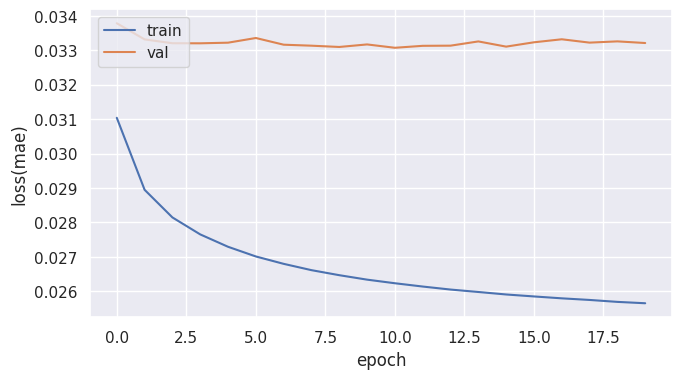

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss(mae)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modelr.evaluate(X_testr,y_testr)

82/82 [==============================] - 2s 26ms/step - loss: 0.0327


0.03265406936407089

In [ ]:
predr = modelr.predict(X_testr)

In [ ]:
del(modelr)
del(X_testr)
del(X_trainr)
del(X_validr)
del(y_testr)
del(y_trainr)
del(y_validr)
del(residual)
gc.collect()

19436

**ADDITIVE DECOMPOSTION to COLLECT TREND**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
trend= {}
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    trend[ts] = decomposition.trend.copy()

trend=pd.DataFrame(trend)
trend.columns=Header
trend=trend.fillna(0)

del(decomposition)
gc.collect()

0

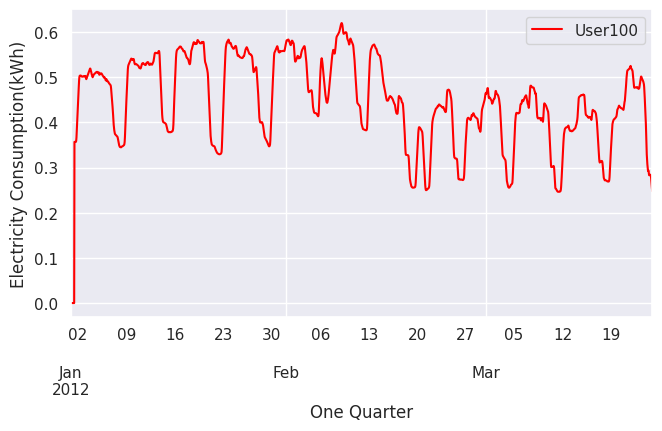

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

trend.iloc[0:2016].plot(y=['User100'] ,color=['red'])

plt.ylabel('Electricity Consumption(kWh)')
plt.xlabel('One Quarter')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Split the data into train and test sets
train_trend,test_trend = trend[0:23673], trend[23673:]
train_trend, valid_trend = trend[0:21306], trend[21306:23673]

In [ ]:
X_traint, y_traint = split_series(train_trend.values,n_past, n_future)
X_traint = X_traint.reshape((X_traint.shape[0], X_traint.shape[1],n_features))
y_traint = y_traint.reshape((y_traint.shape[0], y_traint.shape[1], n_features))
X_testt, y_testt = split_series(test_trend.values,n_past, n_future)
X_testt = X_testt.reshape((X_testt.shape[0], X_testt.shape[1],n_features))
y_testt = y_testt.reshape((y_testt.shape[0], y_testt.shape[1], n_features))
X_validt, y_validt = split_series(valid_trend.values,n_past, n_future)
X_validt = X_validt.reshape((X_validt.shape[0], X_validt.shape[1],n_features))
y_validt = y_validt.reshape((y_validt.shape[0], y_validt.shape[1], n_features))

##St-LSTM Model

In [ ]:
modelt = Sequential()
modelt.add(LSTM(units=128,
                                 return_sequences=False,
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 ))
modelt.add(RepeatVector(n_future))
modelt.add(SeqSelfAttention(attention_activation = 'tanh'))
modelt.add(TimeDistributed(Dense(units=n_features, activation = None)))
modelt.compile(loss='mae', optimizer='adam')
modelt.build((None, n_past, n_features))
modelt.summary()

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 128)               230400    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 3, 128)            0         
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 3, 128)            8257      
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 3, 321)            41409     
Total params: 280,066
Trainable params: 280,066
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#modelt.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history_modelt=modelt.fit(X_traint,y_traint,epochs=20,validation_data=(X_validt,y_validt),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
1330/1330 [==============================] - 56s 40ms/step - loss: 0.0290 - val_loss: 0.0319
Epoch 2/20
1330/1330 [==============================] - 51s 39ms/step - loss: 0.0195 - val_loss: 0.0294
Epoch 3/20
1330/1330 [==============================] - 52s 39ms/step - loss: 0.0174 - val_loss: 0.0280
Epoch 4/20
1330/1330 [==============================] - 51s 38ms/step - loss: 0.0161 - val_loss: 0.0268
Epoch 5/20
1330/1330 [==============================] - 53s 40ms/step - loss: 0.0151 - val_loss: 0.0261
Epoch 6/20
1330/1330 [==============================] - 51s 38ms/step - loss: 0.0143 - val_loss: 0.0252
Epoch 7/20
1330/1330 [==============================] - 53s 40ms/step - loss: 0.0138 - val_loss: 0.0243
Epoch 8/20
1330/1330 [==============================] - 51s 38ms/step - loss: 0.0133 - val_loss: 0.0248
Epoch 9/20
1330/1330 [==============================] - 53s 40ms/step - loss: 0.0129 - val_loss: 0.0241
Epoch 10/20
1330/1330 [==============================] - 51s 38m

In [ ]:
modelt.evaluate(X_testt,y_testt)

82/82 [==============================] - 2s 21ms/step - loss: 0.0261


0.02611328288912773

In [ ]:
predt = modelt.predict(X_testt)

In [ ]:
del(modelt)
del(X_testt)
del(X_traint)
del(X_validt)
del(y_testt)
del(y_traint)
del(y_validt)
del(trend)
gc.collect()

16788

**ADDITIVE DECOMPOSITION to COLLECT SEASONALITY**

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

# Generate example time series data


# Decompose the time series into its trend, seasonal, and residual components using additive decomposition
seasonal ={}
for ts in df.columns:
    decomposition = sm.tsa.seasonal_decompose(dff[ts],model='additive')
    seasonal[ts] = decomposition.seasonal.copy()


seasonal=pd.DataFrame(seasonal)
seasonal.columns=Header
seasonal=seasonal.fillna(0)

del(decomposition)
gc.collect()

0

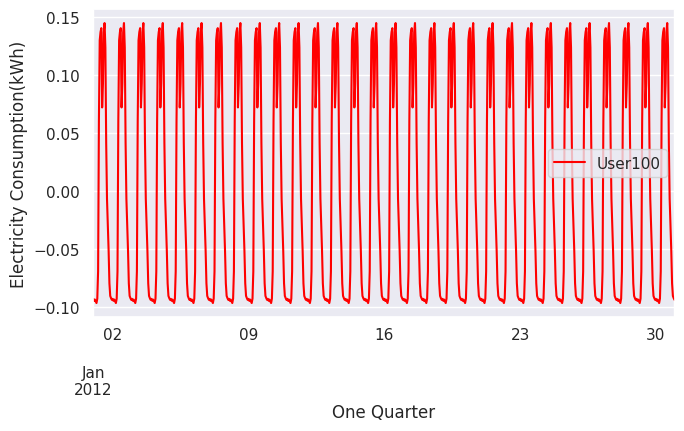

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

seasonal.iloc[0:720].plot(y=['User100'] ,color=['red'])

plt.ylabel('Electricity Consumption(kWh)')
plt.xlabel('One Quarter')
plt.show()

In [ ]:
# Split the data into train and test sets
train_seasonal,test_seasonal = seasonal[0:23673], seasonal[23673:]
train_seasonal, valid_seasonal = seasonal[0:21306], seasonal[21306:23673]

In [ ]:
X_trains, y_trains = split_series(train_seasonal.values,n_past, n_future)
X_trains = X_trains.reshape((X_trains.shape[0], X_trains.shape[1],n_features))
y_trains = y_trains.reshape((y_trains.shape[0], y_trains.shape[1], n_features))
X_tests, y_tests = split_series(test_seasonal.values,n_past, n_future)
X_tests = X_tests.reshape((X_tests.shape[0], X_tests.shape[1],n_features))
y_tests = y_tests.reshape((y_tests.shape[0], y_tests.shape[1], n_features))
X_valids, y_valids = split_series(valid_seasonal.values,n_past, n_future)
X_valids = X_valids.reshape((X_valids.shape[0], X_valids.shape[1],n_features))
y_valids = y_valids.reshape((y_valids.shape[0], y_valids.shape[1], n_features))

##St-LSTM Enc-Dec

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs = encoder(encoder_inputs)
encoder_states = encoder_outputs[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs[0])

decoder = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states)
decoder_outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder)

models = tf.keras.models.Model(encoder_inputs,decoder_outputs)

models.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 321)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        168800      ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 3, 100)      0           ['lstm_1[0][0]']                 
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
models.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_absolute_error')
history_models=models.fit(X_trains,y_trains,epochs=20,validation_data=(X_valids,y_valids),batch_size=16,verbose=1,callbacks=[reduce_lr,es])

Epoch 1/20
1330/1330 [==============================] - 55s 38ms/step - loss: 0.0105 - val_loss: 0.0051 - lr: 0.0010
Epoch 2/20
1330/1330 [==============================] - 48s 36ms/step - loss: 0.0044 - val_loss: 0.0040 - lr: 0.0010
Epoch 3/20
1330/1330 [==============================] - 50s 38ms/step - loss: 0.0030 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/20
1330/1330 [==============================] - 48s 36ms/step - loss: 0.0023 - val_loss: 0.0021 - lr: 0.0010
Epoch 5/20
1330/1330 [==============================] - 47s 36ms/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/20
1330/1330 [==============================] - 47s 35ms/step - loss: 0.0017 - val_loss: 0.0013 - lr: 0.0010
Epoch 7/20
1330/1330 [==============================] - 48s 36ms/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0010
Epoch 8/20
1330/1330 [==============================] - 50s 37ms/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0010
Epoch 9/20
1330/1330 [==============================] - 52s 39ms

In [ ]:
models.evaluate(X_tests,y_tests)

82/82 [==============================] - 1s 17ms/step - loss: 5.8316e-04


0.0005831622402183712

In [ ]:
preds = models.predict(X_tests)

82/82 [==============================] - 2s 18ms/step


In [ ]:
del(models)
del(X_tests)
del(X_trains)
del(X_valids)
del(y_tests)
del(y_trains)
del(y_valids)
del(seasonal)
gc.collect()

10783

##Prediction Fusion

In [ ]:
pred = preds + predt + predr
print(pred.shape)

(2603, 3, 321)


In [ ]:
train,test = df[0:23673], df[23673:]
train, valid = df[0:21306], df[21306:23673]

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_valid, y_valid = split_series(valid.values,n_past, n_future)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1],n_features))
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1], n_features))

In [ ]:
mean_array = dff.mean(axis = 0)
y_test_std = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
#y_tst = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
#y_tst =  y_test.mean(axis = 1)
for i in range(y_test.shape[0]):
  for j in range(y_test.shape[1]):
    y_test_std[i][j] = (y_test[i][j] - mean_array)* (y_test[i][j] - mean_array) #n x n_future x num_user

y_test_sum = y_test_std.mean(axis = 1) # n x num_user

##RSE & RSquare

In [ ]:
diff = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
diff = (y_test-pred)*(y_test-pred)
diff_sum = diff.mean(axis = 1)


diff_ = diff_sum.mean(axis = 1)
y_ = y_test_sum.mean(axis = 1)
diff__ = diff_.sum()
y__ = y_.sum()
rsquare = 1 - (diff__/y__)
rse = np.sqrt(diff__)/np.sqrt(y__)
print(rse)
print(rsquare)

0.40817197989209547
0.8333956348309668


In [ ]:
squared_diff_actual_pred = np.square(y_test - pred)

# Calculate squared differences between actual matrix and mean of actual matrix
mean_actual = np.mean(y_test)
squared_diff_actual_mean = np.square(y_test - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff_actual_pred)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE):", rse)

Root Relative Squared Error (RSE): 0.33493534698339306


In [ ]:
actual_flat = y_test.flatten()
prediction_flat = pred.flatten()

# Calculate squared differences between actual and prediction values
squared_diff = np.square(actual_flat - prediction_flat)

# Calculate squared differences between actual values and mean of actual values
mean_actual = np.mean(actual_flat)
squared_diff_actual_mean = np.square(actual_flat - mean_actual)

# Sum squared differences along all elements
sum_squared_diff_actual_pred = np.sum(squared_diff)
sum_squared_diff_actual_mean = np.sum(squared_diff_actual_mean)

# Calculate RSE
rse = np.sqrt(sum_squared_diff_actual_pred / sum_squared_diff_actual_mean)

print("Root Relative Squared Error (RSE) with flattened matrices:", rse)

Root Relative Squared Error (RSE) with flattened matrices: 0.33493534698339306


In [ ]:
rmse = np.sqrt(np.mean((y_test - pred)**2))

# Calculate range of true values
denom=np.sqrt(np.mean((y_test - np.mean(y_test))**2))
rrse = rmse / denom
print("Root Relative Squared Error (RRSE):", rrse)

Root Relative Squared Error (RRSE): 0.3349353469833931


##CORR

In [ ]:
# y_true_mean = np.mean(y_test, axis=(1, 2), keepdims=True)
# y_pred_mean = np.mean(pred, axis=(1, 2), keepdims=True)

# y_true_diff = y_test - y_true_mean
# y_pred_diff = pred - y_pred_mean

# sum_product_diff = np.sum(y_true_diff * y_pred_diff, axis=(1, 2), keepdims=True)

# squared_sum_diff_y = np.sum(y_true_diff ** 2, axis=(1, 2), keepdims=True)

# squared_sum_diff_y_hat = np.sum(y_pred_diff ** 2, axis=(1, 2), keepdims=True)
# # Stabilize the denominator to avoid division by zero
# eps = 1e-8
# corr_matrix = sum_product_diff / (np.sqrt(squared_sum_diff_y * squared_sum_diff_y_hat) + eps)


# corr = np.mean(corr_matrix)

# print(corr)

#corr using function

In [ ]:
flat_matrix_1 =y_test.flatten()
flat_matrix_2 = pred.flatten()

# Calculate the correlation coefficient between the flattened arrays
correlation = np.corrcoef(flat_matrix_1, flat_matrix_2)[0, 1]

print("Correlation between the two 3D matrices:", correlation)



Correlation between the two 3D matrices: 0.9437845389348007


#corr according to lstnet

In [ ]:
y_true_mean= np.mean(y_test,axis=(1),keepdims=True)
# print(y_true_mean.shape)
y_pred_mean = np.mean(pred, axis=(1),keepdims=True)
# print(y_pred_mean.shape)

#for num
# print("num")
y_true_diff = y_test - y_true_mean
# print(y_true_diff.shape)

y_pred_diff = pred - y_pred_mean
# print(y_true_diff.shape)

sum_product_diff = y_true_diff * y_pred_diff
# print(sum_product_diff.shape)

num= np.sum(sum_product_diff,axis=1,keepdims=True)
# print(num.shape)

# print("")
# print("denom")
#for denom
y_true_diff_squared=y_true_diff**2
# print(y_true_diff_squared.shape)

y_pred_diff_squared =y_pred_diff**2
# print(y_true_diff_squared.shape)

sum_product_diff_squared = y_true_diff_squared * y_pred_diff_squared
# print(sum_product_diff_squared.shape)

denom_squared= np.sum(sum_product_diff_squared,axis=1,keepdims=True)
# print(denom_squared.shape)

denom=np.sqrt(denom_squared)
# print(denom.shape)
#division
# print("division")
eps = 1e-8
division= num/(denom+eps)
# print(division.shape)


print("corr")
corr_test=np.mean(division,axis=0)
# print(corr_test.shape)
# print(corr_test)
corr_final=np.mean(corr_test)

print(corr_final)




corr
0.8380981554338343


##MAE

In [ ]:
dif = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
dif = np.abs(y_test-pred)
dif_sum = dif.mean(axis = 1)


dif_ = dif_sum.mean(axis = 1)
dif__ = dif_.sum()
print(dif__/y_test.shape[0])

0.04262186612556698


##SMAPE

In [ ]:
top = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
top = np.abs(y_test-pred)
bottom = (np.abs(y_test)+np.abs(pred))/2
val = top/bottom
val_ = val.mean(axis = 1)
val__ = val_.mean(axis = 1)
val___ = val__.sum()
smap = ((val___)/y_test.shape[0])
print(smap)

0.15536832898409653


##Plot predict vs actual

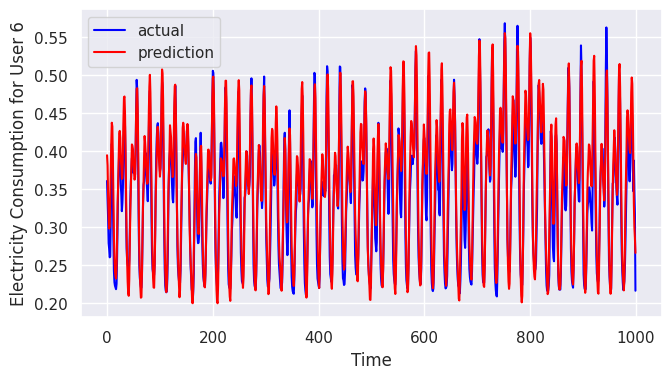

In [ ]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(7.5,4)})

meanpred = np.zeros((y_test.shape[0],y_test.shape[1],y_test.shape[2]))
meanpred = pred.mean(axis=1)

b = pd.DataFrame(y_test.mean(axis=1))
b.columns = Header
b=b.iloc[0:1000][:]
plt.plot(b['User6'],label="actual",color='blue')

a = pd.DataFrame(meanpred)
a.columns = Header
a=a.iloc[0:1000][:]
plt.plot(a['User6'],label="prediction",color='red')


plt.ylabel('Electricity Consumption for User 6')
plt.xlabel('Time')
plt.legend()
#plt.show()